**Problem**  
The goal of this competition was to create a dog that looked indistinguishable from a real dog using a Generator and a Discriminator network. Provided is a large dataset and the performance is based off of MiFID..

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import xml.etree.ElementTree as ET
from IPython.display import display, clear_output
from tensorflow.keras.preprocessing.image import load_img, img_to_array

**Data**  
The total number of images is 20,579 each of varying size and containing a dog. To clean the data we need to normalize the images and make sure they are recentered. All the annotations also have XML files which will need to be properly read and mapped.  

**EDA**  
Looking at the dataset and problem we have, the clear solution is going to be creating a GAN and require methods for parsing information and loading images and preprocessing them as we go along and train. The dataset is rather large given the amount of information in an individual image we know we will need to scale down the images and they will be normalized in preparing the dataset for the models.

In [ ]:
annotations_root = 'Data/Annotation'
images_root = 'Data/all-dogs'

class_name_to_label = {}
breed_code_to_name = {}

for subfolder in os.listdir(annotations_root):
    class_name = subfolder.split('-')[1]
    if class_name not in class_name_to_label:
        class_name_to_label[class_name] = len(class_name_to_label)

    subfolder_path = os.path.join(annotations_root, subfolder)
    for xml_file in os.listdir(subfolder_path):
        xml_file_path = os.path.join(subfolder_path, xml_file)

for subfolder in os.listdir(annotations_root):
    parts = subfolder.split('-')
    breed_code, class_name = parts[0], parts[1]
    
    breed_code_to_name[breed_code] = class_name
    if class_name not in class_name_to_label:
        class_name_to_label[class_name] = len(class_name_to_label)

In [ ]:
def parse_annotation(annotation_path):
    if not os.path.exists(annotation_path):
        return None
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    bndbox = root.find(".//bndbox")
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def load_image_and_annotation(image_path):
    filename = os.path.basename(image_path)
    breed_code = filename.split('_')[0]

    breed_name = breed_code_to_name.get(breed_code)
    if breed_name is None:
        return None

    label = class_name_to_label.get(breed_name)
    if label is None:
        return None

    image = Image.open(image_path).resize(IMAGE_SIZE)
    image = np.array(image) / 127.5 - 1

    annotation_filename = filename.replace('.jpg', '.xml')
    annotation_path = os.path.join(annotations_root, f"{breed_code}-{breed_name}", annotation_filename)
    bbox = parse_annotation(annotation_path)
    if bbox is None:
        return None

    return image, tf.one_hot(label, depth=len(class_name_to_label)), bbox

image_paths = []
for root, dirs, files in os.walk(images_root):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

def prepare_dataset(image_paths):
    images = []
    labels = []
    bboxes = []

    for image_path in image_paths:
        result = load_image_and_annotation(image_path)
        if result:
            image, label, bbox = result
            images.append(image)
            labels.append(label)
            bboxes.append(bbox)

    if not images:
        raise ValueError("No images were loaded; check your image paths and annotations.")

    buffer_size = len(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels, bboxes))
    dataset = dataset.shuffle(buffer_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

dataset = prepare_dataset(image_paths)

In [ ]:
for images, original_sizes in dog_dataset.unbatch().take(-1):
    total_images += 1
    size_str = f"{original_sizes[0].numpy()}x{original_sizes[1].numpy()}"
    if size_str in size_distributions:
        size_distributions[size_str] += 1
    else:
        size_distributions[size_str] = 1

**Models**  
The models we are going to use are a generator model and a discriminator model. Together these comprise the Generative Adversarial Network (GAN). We use these because together they are able to generation of new images that can mimic what they were trained on and for this instance it will be dogs. 

In [4]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
    ])
    return model


In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint_manager.save()
            print(f'Checkpoint saved at epoch {epoch+1}')

        print(f'Epoch {epoch + 1}/{epochs} completed')

    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [7]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


**Results and Conclusion**  
The initial results of the GAN were not of great quality, but that outcome was relatively expected because of the number of epochs and the amount of tuning and experimenting that is required to go into these models. Given time and tuning of hyperparameters I think the results could be much more recognizable.  
The primary takeaway from this is increasing the number of training epochs, optimizing model parameters and potentially exploring other GAN architectures. The layers used in the models in this project were not necessarily the most optimized as well.

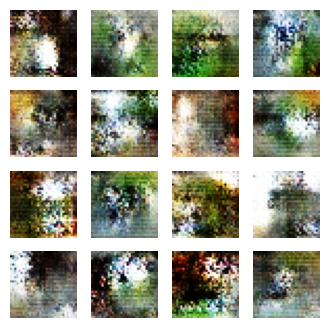

In [8]:
EPOCHS = 50
train(dog_dataset, EPOCHS)


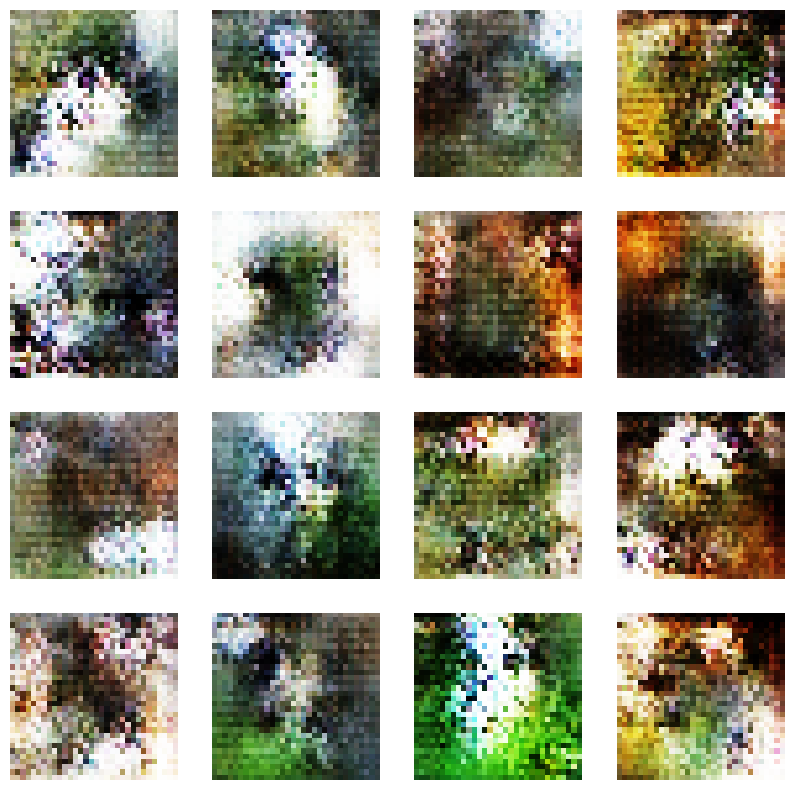

In [9]:
noise = tf.random.normal([num_examples_to_generate, noise_dim])

generated_images = generator(noise, training=False)

plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, :] * 0.5 + 0.5)
    plt.axis('off')
plt.show()
